In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import karateclub
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")


In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
TOP = os.getcwd().replace('notebooks', '')

In [4]:
processed_dir = TOP + 'data/processed/'

In [5]:
figures_dir = TOP + 'reports/figures/'

In [6]:
genetox_outcomes = pd.read_csv(processed_dir+'genetox_outcomes.csv',index_col=0)
genetox_outcomes

,DTXSID,outcome,SMILES
0,DTXSID00148597,1,ClCC1=C2C=CC3=CC=CC4=C3C2=C(C=C1)C=C4
1,DTXSID00157169,1,CCNC1=C(O)C(Cl)=CC(=C1)[N+]([O-])=O
2,DTXSID00159204,0,CCO[Si](C)(CCCCl)OCC
3,DTXSID00160734,0,NCCCC(O)(P(O)(O)=O)P(O)(O)=O
4,DTXSID00162834,0,CNCC1=CC=CC2=CC=CC=C12
...,...,...,...
5398,DTXSID90890477,0,COC1=C(NC2=NC(SCCCS(O)(=O)=O)=NC(SCCCS(O)(=O)=...
5399,DTXSID90890619,0,OC(=O)C1=C(C=CC=C1)N=NC1=C2C=CC=CC2=CC=C1O
5400,DTXSID90890811,0,CCCCCCCCCC1=CC2=CC=CC=C2C(=C1CCCCCCCCC)S(O)(=O)=O
5401,DTXSID90891080,0,CC1=C(Cl)C=C(N=NC2=C(O)C=CC3=CC=CC=C23)C(=C1)S...


In [7]:

smile_outcome_dict = dict(zip(list(genetox_outcomes.SMILES),list(genetox_outcomes.outcome)))

In [8]:
fps = []
for smile in list(smile_outcome_dict.keys()):
    mol = Chem.MolFromSmiles(smile)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,3,1024)))

X_fps = np.array(fps)
y = list(smile_outcome_dict.values())

knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score))

In [9]:
print(cv['test_score'].mean())

0.6629804009404847


In [10]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.7266823641974589


In [11]:
def smile_to_mol_graph(smile):
    new_graph = nx.Graph()
    mol = Chem.MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        new_graph.add_node(atom.GetIdx(),
                           feature=atom.GetSymbol())
    for bond in mol.GetBonds():
        new_graph.add_edge(bond.GetBeginAtomIdx(),
                           bond.GetEndAtomIdx())
    
    return new_graph


In [12]:
mol_graphs = [smile_to_mol_graph(smile) for smile in list(smile_outcome_dict.keys())]

In [30]:
#smile_outcome_dict



In [13]:
my_dict = {k:v for k,v in zip(genetox_outcomes['SMILES'], genetox_outcomes['DTXSID'])}

In [14]:
def mol_embed(m, g):
    m.fit(g)
    X_embedding = m.get_embedding()
    tsne = TSNE(n_components=2,random_state=42)
    z = tsne.fit_transform(np.array(X_embedding))
    return z

In [15]:
results = {}
for model in [karateclub.LDP(), karateclub.GL2Vec(), karateclub.Graph2Vec(attributed=True)]:
    results[model] = mol_embed(model, mol_graphs)

In [30]:
#results

In [17]:
mydfs = []
for k, v in results.items():
    df = pd.DataFrame(v, columns = ['comp_1', 'comp_2'])
    df['approach'] = str(k)
    df2 = pd.DataFrame(list(smile_outcome_dict.items()))
    df = pd.concat([df,df2], axis =1)
    df.columns = ['comp_1', 'comp_2','approach','smiles', 'genetox_outcome']
    df['dtxsid'] = df['smiles'].replace(my_dict)
    mydfs.append(df)

In [18]:
mydfs[0]['approach'] = mydfs[0]['approach'].replace('<karateclub.graph_embedding.ldp.LDP object at 0x797d25be43d0>','LDP')

In [19]:
results.keys()

dict_keys([<karateclub.graph_embedding.ldp.LDP object at 0x75a14f823b50>, <karateclub.graph_embedding.gl2vec.GL2Vec object at 0x75a14f823b20>, <karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x75a14f8235e0>])

In [48]:
#mydfs[0]

In [22]:
mydfs[1]['approach'] =  mydfs[1]['approach'].replace('<karateclub.graph_embedding.gl2vec.GL2Vec object at 0x797d25be4400>','GL2Vec')
mydfs[2]['approach'] =  mydfs[2]['approach'].replace('<karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x797d25be41f0>','graph2vec')

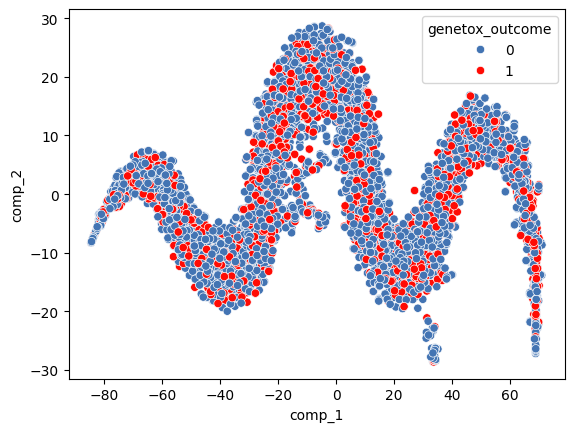

In [28]:
#df['genetox_outcome'] = df['genetox_outcome'].astype(str)
colors = ["#4374B3","#FF0B04",]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='comp_1',y='comp_2', hue='genetox_outcome', data=mydfs[2])
plt.savefig(figures_dir+'Graph2Vec_050824.png', dpi = 300)


In [31]:
knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,list(results.values())[0],y,cv=5,scoring=make_scorer(roc_auc_score))
print(cv['test_score'].mean())

0.5962391941246116


In [32]:
knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,list(results.values())[1],y,cv=5,scoring=make_scorer(roc_auc_score))
print(cv['test_score'].mean())

0.604335066616321


In [33]:
knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,list(results.values())[2],y,cv=5,scoring=make_scorer(roc_auc_score))
print(cv['test_score'].mean())

0.5263896054492455


In [34]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,list(results.values())[0],y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.5485704416473681


In [35]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,list(results.values())[1],y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.5986226009860853


In [36]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,list(results.values())[2],y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.5003833007010743


In [21]:
for k, v in results.items():
    for model in [knn, lr]:
        if model == knn:
            cv = cross_validate(model,v,y,cv=5,scoring=make_scorer(roc_auc_score))
            a = cv['test_score'].mean()
        else:
            cv = cross_validate(model,v,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
            a = cv['test_score'].mean()
        print(k, a, model)

<karateclub.graph_embedding.ldp.LDP object at 0x75a14f823b50> 0.5962391941246116 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.ldp.LDP object at 0x75a14f823b50> 0.5485704416473681 LogisticRegression(n_jobs=-1)
<karateclub.graph_embedding.gl2vec.GL2Vec object at 0x75a14f823b20> 0.604335066616321 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.gl2vec.GL2Vec object at 0x75a14f823b20> 0.5986226009860853 LogisticRegression(n_jobs=-1)
<karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x75a14f8235e0> 0.5263896054492455 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x75a14f8235e0> 0.5003833007010743 LogisticRegression(n_jobs=-1)
